### **Importing Libraries**

In [1]:
import pickle
import re
import spacy
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
import torch
from torch import nn
import torch.nn.functional as F

### **Mounting Google derive**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
seed = 2019
torch.manual_seed(seed)

### **Loading the Data**

In [4]:
with open('/content/drive/MyDrive/Dailog-dataset.dialogs_dataset','rb') as f:
 df = pickle.load(f)
df[:10]

["Hi, I'm looking to book a table for Korean fod",
 'Somewhere in Southern NYC, maybe the East Village?',
 " We don't want to sit at the bar, but anywhere else is fine",
 'What times are available?',
 "Yikes, we can't do those times",
 'Let me check',
 "Great, let's book that",
 "No, that's it, just book",
 'Hi I would like to see if the Movie What Men Want is playing here',
 'Yes, for me and a friend so two tickets please']

### **Preparing data**

In [5]:
type(df)

list

In [6]:
clean_df = []
for i in df:
  i = re.sub("[^a-zA-Z']"," ",i)
  i = i.lower()
  clean_df.append(i)

In [7]:
clean_df[:10]

["hi  i'm looking to book a table for korean fod",
 'somewhere in southern nyc  maybe the east village ',
 " we don't want to sit at the bar  but anywhere else is fine",
 'what times are available ',
 "yikes  we can't do those times",
 'let me check',
 "great  let's book that",
 "no  that's it  just book",
 'hi i would like to see if the movie what men want is playing here',
 'yes  for me and a friend so two tickets please']

In [8]:
all_text = " ".join(clean_df)

In [9]:
token = all_text.split()
BOW = {}
for word in token:
  if word not in BOW.keys():
    BOW[word] = 1
  else:
    BOW[word] +=1


In [10]:
word_count = pd.DataFrame({'word':BOW.keys(),'count':BOW.values()})
word_count = word_count.sort_values(by = ['count'])

In [11]:
word_count.head()

,word,count
10949,tabs,1
7881,genres,1
4217,gakus,1
7882,indecisive,1
7883,emagine,1


In [12]:
word_count.tail()

,word,count
69,you,11928
5,a,13390
3,to,14003
15,the,15410
47,i,19881


In [13]:
rare_threshold = 3

rare_words = len(word_count[word_count['count'] < rare_threshold]) ## Selecting all the words that appear less than 3 times in whole text as rare words
total_words = len(word_count)

In [14]:
rare_words_dist = rare_words/total_words*100
rare_words_corpus = word_count[word_count['count'] < rare_threshold]['count'].sum()/word_count['count'].sum()*100

In [15]:
print('The rare words percentage distribution :',rare_words_dist)
print('The rare words percentage distribution in corpus:',rare_words_corpus)

The rare words percentage distribution : 61.61643835616438
The rare words percentage distribution in corpus: 1.742686062912748


In [16]:
rare_words = word_count[word_count['count'] < rare_threshold]['word'].tolist()
rare_words[:10]

['tabs',
 'genres',
 'gakus',
 'indecisive',
 'emagine',
 'brissago',
 "monster's",
 'idk',
 'thingy',
 'lucas']

In [17]:
data = []                                 
for sents in tqdm_notebook(clean_df):
  for word in sents:                           # Removing the rare words with unknown token in text
    if word in rare_words:
      sent = re.sub(word,'<unk>',sents)
      data.append(sent)

  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [18]:
data[:10]

['hi  i<unk>m looking to book a table for korean fod',
 ' we don<unk>t want to sit at the bar  but anywhere else is fine',
 'yikes  we can<unk>t do those times',
 'great  let<unk>s book that',
 'no  that<unk>s it  just book',
 'let<unk>s watch another movie then',
 'let<unk>s watch how to train your dragon',
 'i want to order a pi<unk><unk>a from bertuccis in chelmsford  ma',
 'i want to order a pi<unk><unk>a from bertuccis in chelmsford  ma',
 ' i would like a sporkie pi<unk><unk>a']

In [19]:
len(token)

477137

In [20]:
# capture length of all the sequences

text_word_count = []
for i in data:
  text_word_count.append(len(i.split()))

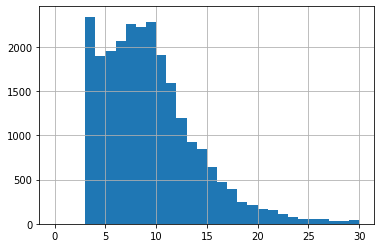

In [21]:
pd.Series(text_word_count).hist(bins = 30,range = (0,30))

In [22]:
def create_seq(text,seq_len = 8):           # Choose sequence length 8 as most of the sentence in text are of less than 10 

  sequences = []

  if len(text.split()) > seq_len:
    for i in range(seq_len,len(text.split())):
      seq = text.split()[i-seq_len:i+1]
      sequences.append(" ".join(seq))
    return sequences

  else:
    return [text]

 

In [23]:
seqs = [create_seq(i) for i in data]

In [24]:
seqs[:15]

[['hi i<unk>m looking to book a table for korean',
  'i<unk>m looking to book a table for korean fod'],
 ['we don<unk>t want to sit at the bar but',
  'don<unk>t want to sit at the bar but anywhere',
  'want to sit at the bar but anywhere else',
  'to sit at the bar but anywhere else is',
  'sit at the bar but anywhere else is fine'],
 ['yikes  we can<unk>t do those times'],
 ['great  let<unk>s book that'],
 ['no  that<unk>s it  just book'],
 ['let<unk>s watch another movie then'],
 ['let<unk>s watch how to train your dragon'],
 ['i want to order a pi<unk><unk>a from bertuccis in',
  'want to order a pi<unk><unk>a from bertuccis in chelmsford',
  'to order a pi<unk><unk>a from bertuccis in chelmsford ma'],
 ['i want to order a pi<unk><unk>a from bertuccis in',
  'want to order a pi<unk><unk>a from bertuccis in chelmsford',
  'to order a pi<unk><unk>a from bertuccis in chelmsford ma'],
 [' i would like a sporkie pi<unk><unk>a'],
 [' i would like a sporkie pi<unk><unk>a'],
 ['hi i<unk>d 

In [25]:
seqs = sum(seqs,[])

In [26]:
seqs[:15]

['hi i<unk>m looking to book a table for korean',
 'i<unk>m looking to book a table for korean fod',
 'we don<unk>t want to sit at the bar but',
 'don<unk>t want to sit at the bar but anywhere',
 'want to sit at the bar but anywhere else',
 'to sit at the bar but anywhere else is',
 'sit at the bar but anywhere else is fine',
 'yikes  we can<unk>t do those times',
 'great  let<unk>s book that',
 'no  that<unk>s it  just book',
 'let<unk>s watch another movie then',
 'let<unk>s watch how to train your dragon',
 'i want to order a pi<unk><unk>a from bertuccis in',
 'want to order a pi<unk><unk>a from bertuccis in chelmsford',
 'to order a pi<unk><unk>a from bertuccis in chelmsford ma']

In [27]:
len(seqs)

67993

In [28]:
x = []
y = []

for i in seqs:
  x.append(" ".join(i.split()[:-1]))
  y.append(" ".join(i.split()[1:]))



In [29]:
x[0]  , y[0]

('hi i<unk>m looking to book a table for',
 'i<unk>m looking to book a table for korean')

In [30]:
int2token = {}                              # Giving each token or word in text a unique interger name which help in converting text into integer
cnt = 1

for w in set(" ".join(data).split()):
  int2token[cnt] = w
  cnt +=1

token2int = {t:i for i,t in int2token.items()}


In [31]:
token2int['can']

5714

In [32]:
int2token[5181]

'monster'

In [33]:
x_tr = x[:50000]
y_tr = y[:50000]

x_val = x[50000:]
y_val = y[50000:]

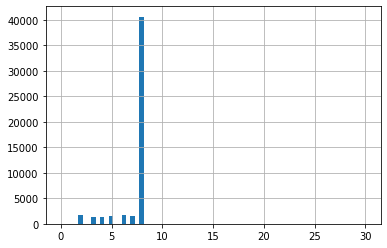

In [34]:
# plot sequence length in train set
text_word_count = []

for i in x_tr:
  text_word_count.append(len(i.split()))

pd.Series(text_word_count).hist(bins = 70,range=(0,30))

In [35]:
max_text_len = 8                           # Padding the sequence to make it of equal length

def pad_sequence(seq,n):
  seq = seq.split()

  if len(seq) < 8:
    for i in range(n-len(seq)):
      seq.append('<pad>')

  return " ".join(seq)


In [36]:
x_tr_padded = [pad_sequence(s,max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s,max_text_len) for s in y_tr]

x_val_padded = [pad_sequence(s,max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s,max_text_len) for s in y_val]

In [37]:
x_tr_padded[:20]

['hi i<unk>m looking to book a table for',
 'i<unk>m looking to book a table for korean',
 'we don<unk>t want to sit at the bar',
 'don<unk>t want to sit at the bar but',
 'want to sit at the bar but anywhere',
 'to sit at the bar but anywhere else',
 'sit at the bar but anywhere else is',
 'yikes we can<unk>t do those <pad> <pad> <pad>',
 'great let<unk>s book <pad> <pad> <pad> <pad> <pad>',
 'no that<unk>s it just <pad> <pad> <pad> <pad>',
 'let<unk>s watch another movie <pad> <pad> <pad> <pad>',
 'let<unk>s watch how to train your <pad> <pad>',
 'i want to order a pi<unk><unk>a from bertuccis',
 'want to order a pi<unk><unk>a from bertuccis in',
 'to order a pi<unk><unk>a from bertuccis in chelmsford',
 'i want to order a pi<unk><unk>a from bertuccis',
 'want to order a pi<unk><unk>a from bertuccis in',
 'to order a pi<unk><unk>a from bertuccis in chelmsford',
 'i would like a sporkie <pad> <pad> <pad>',
 'i would like a sporkie <pad> <pad> <pad>']

In [38]:
y_tr_padded[:20]

['i<unk>m looking to book a table for korean',
 'looking to book a table for korean fod',
 'don<unk>t want to sit at the bar but',
 'want to sit at the bar but anywhere',
 'to sit at the bar but anywhere else',
 'sit at the bar but anywhere else is',
 'at the bar but anywhere else is fine',
 'we can<unk>t do those times <pad> <pad> <pad>',
 'let<unk>s book that <pad> <pad> <pad> <pad> <pad>',
 'that<unk>s it just book <pad> <pad> <pad> <pad>',
 'watch another movie then <pad> <pad> <pad> <pad>',
 'watch how to train your dragon <pad> <pad>',
 'want to order a pi<unk><unk>a from bertuccis in',
 'to order a pi<unk><unk>a from bertuccis in chelmsford',
 'order a pi<unk><unk>a from bertuccis in chelmsford ma',
 'want to order a pi<unk><unk>a from bertuccis in',
 'to order a pi<unk><unk>a from bertuccis in chelmsford',
 'order a pi<unk><unk>a from bertuccis in chelmsford ma',
 'would like a sporkie pi<unk><unk>a <pad> <pad> <pad>',
 'would like a sporkie pi<unk><unk>a <pad> <pad> <pad>']

In [39]:
int2token[0] = '<pad>'
token2int['<pad>'] = 0

In [40]:
vocab_size = len(int2token)

In [41]:
vocab_size

6775

In [42]:
def get_integer_seq(seq):
  return[token2int[w] for w in seq.split()]

In [43]:
# convert text sequences to integer sequences
x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

In [44]:
x_tr_int[:10]

[[4596, 6176, 3669, 2229, 2735, 1380, 1644, 4094],
 [6176, 3669, 2229, 2735, 1380, 1644, 4094, 3308],
 [4549, 5861, 3560, 2229, 5514, 5944, 2877, 5127],
 [5861, 3560, 2229, 5514, 5944, 2877, 5127, 2453],
 [3560, 2229, 5514, 5944, 2877, 5127, 2453, 3819],
 [2229, 5514, 5944, 2877, 5127, 2453, 3819, 3882],
 [5514, 5944, 2877, 5127, 2453, 3819, 3882, 722],
 [6274, 4549, 3038, 2887, 1268, 0, 0, 0],
 [2351, 4861, 2735, 0, 0, 0, 0, 0],
 [6772, 5252, 5138, 311, 0, 0, 0, 0]]

In [45]:
y_tr_int[:10]

[[6176, 3669, 2229, 2735, 1380, 1644, 4094, 3308],
 [3669, 2229, 2735, 1380, 1644, 4094, 3308, 182],
 [5861, 3560, 2229, 5514, 5944, 2877, 5127, 2453],
 [3560, 2229, 5514, 5944, 2877, 5127, 2453, 3819],
 [2229, 5514, 5944, 2877, 5127, 2453, 3819, 3882],
 [5514, 5944, 2877, 5127, 2453, 3819, 3882, 722],
 [5944, 2877, 5127, 2453, 3819, 3882, 722, 2697],
 [4549, 3038, 2887, 1268, 4516, 0, 0, 0],
 [4861, 2735, 3522, 0, 0, 0, 0, 0],
 [5252, 5138, 311, 2735, 0, 0, 0, 0]]

In [46]:
x_tr_int = np.array(x_tr_int)                     # converting data into array
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

In [47]:
x_tr_int.shape ,y_tr_int.shape ,x_val_int.shape , y_val_int.shape

((50000, 8), (50000, 8), (17993, 8), (17993, 8))

In [48]:
# define model architecture

## embedding layer: 
##    input dim = vocab_size, 
##    ouput dim = 200

## LSTM layer:
##    input dim = 200
##    hidden units = 256
##    layers = 2
##    output dim = 256

## Dropout Layer
##    input dim = 256
##    output dim = 256

## fully connected layer
##    input dim = 256
##    ouput dim = vocab_size

class WordLSTM(nn.Module):
      
  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    
    self.emb_layer = nn.Embedding(vocab_size, 200)

    ## define the LSTM
    # input data is of shape (batch size, sequence length, no. of features)...
    # ...therefore we need batch_first=True
    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)
    
    ## define a dropout layer
    self.dropout = nn.Dropout(drop_prob)
    
    ## define the fully-connected layer
    self.fc = nn.Linear(n_hidden, vocab_size)      
  
  def forward(self, x, hidden):
    ''' Forward pass through the network. 
        These inputs are x, and the hidden/cell state is `hidden`. '''

    ## pass input through embedding layer
    embedded = self.emb_layer(x)     
    
    ## Get the outputs and the new hidden state from the lstm
    lstm_output, hidden = self.lstm(embedded, hidden)
    
    ## pass through a dropout layer
    out = self.dropout(lstm_output)
    
    ## reshape the tensor to the shape (batch-size*sequence length, hidden units)
    out = out.reshape(-1, self.n_hidden)

    ## put "out" through the fully-connected layer
    out = self.fc(out)

    # return the final output and the hidden state
    return out, hidden
    
    
  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data

    if (torch.cuda.is_available()):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden

In [49]:
net = WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(6775, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6775, bias=True)
)


In [50]:
# function to generate batches
def get_batches(arr_x, arr_y, batch_size):
  # iterate through the arrays
  prv = 0
  
  for n in range(batch_size, arr_x.shape[0], batch_size):
    # batch of input sequences
    x = arr_x[prv:n,:]

    # batch of target sequences
    y = arr_y[prv:n,:]

    prv = n
    
    yield x, y

In [51]:
def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):
      
  # set initial loss to infinite
  best_valid_loss = float('inf')
  
  # optimizer
  opt = torch.optim.Adam(net.parameters(), lr=lr)
  
  # loss function
  criterion = nn.CrossEntropyLoss()
  
  if(torch.cuda.is_available()):
    # push model to GPU
    net.cuda()
  
  counter = 0

  net.train()

  for e in range(epochs):
            

    # iterate over batches
    for x, y in get_batches(x_tr_int, y_tr_int, batch_size):
      counter+= 1
      
      # convert arrays to tensors
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
      
      if(torch.cuda.is_available()):
        # push tensors to GPU
        inputs, targets = inputs.cuda(), targets.cuda()

      # initialize hidden state
      h = net.init_hidden(batch_size)

      # set accumulated gradients to zero
      net.zero_grad()
      
      # get the output from the model
      output, h = net(inputs, h)
      
      # calculate the loss and perform backprop
      loss = criterion(output, targets.view(-1))
      loss.backward()
      
      opt.step()
      
      if counter % print_every == 0:
        # Get validation loss
        
        val_losses = []

        net.eval()
        for x, y in get_batches(x_val_int, y_val_int, batch_size):
            
          x, y = torch.from_numpy(x), torch.from_numpy(y)
          
          val_h = net.init_hidden(batch_size)

          inputs, targets = x, y
          if(torch.cuda.is_available()):
            inputs, targets = inputs.cuda(), targets.cuda()

          output, val_h = net(inputs, val_h)

          val_loss = criterion(output, targets.view(-1))
          val_losses.append(val_loss.item())

        #save the best model
        if np.mean(val_losses) < best_valid_loss:
          best_valid_loss = np.mean(val_losses)
          torch.save(net.state_dict(), 'saved_weights.pt')

        net.train()

      
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [52]:
# specify batch size
batch_size = 64

# train the model
train(net, batch_size = batch_size, epochs=10)

Epoch: 1/10... Step: 32... Loss: 6.4530... ppl: 446.1121  Val Loss: 6.1006
Epoch: 1/10... Step: 64... Loss: 5.1180... ppl: 311.0262  Val Loss: 5.7399
Epoch: 1/10... Step: 96... Loss: 5.4498... ppl: 273.5889  Val Loss: 5.6116
Epoch: 1/10... Step: 128... Loss: 5.5312... ppl: 219.5122  Val Loss: 5.3914
Epoch: 1/10... Step: 160... Loss: 5.4962... ppl: 198.5211  Val Loss: 5.2909
Epoch: 1/10... Step: 192... Loss: 6.1670... ppl: 179.3302  Val Loss: 5.1892
Epoch: 1/10... Step: 224... Loss: 5.5782... ppl: 167.7657  Val Loss: 5.1226
Epoch: 1/10... Step: 256... Loss: 5.4947... ppl: 157.3091  Val Loss: 5.0582
Epoch: 1/10... Step: 288... Loss: 4.4379... ppl: 148.4424  Val Loss: 5.0002
Epoch: 1/10... Step: 320... Loss: 4.8714... ppl: 139.5263  Val Loss: 4.9383
Epoch: 1/10... Step: 352... Loss: 5.2926... ppl: 130.8630  Val Loss: 4.8742
Epoch: 1/10... Step: 384... Loss: 4.2742... ppl: 124.6333  Val Loss: 4.8254
Epoch: 1/10... Step: 416... Loss: 4.0556... ppl: 119.3471  Val Loss: 4.7820
Epoch: 1/10... 

In [53]:
#load weights of best model
path = 'saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [54]:
# function to generate one token
def predict(net, tkn, h=None):
         
  # tensor inputs
  x = np.array([[token2int[tkn]]])
  inputs = torch.from_numpy(x)
  
  if(torch.cuda.is_available()):
      inputs = inputs.cuda()

  # get the output of the model
  out, h = net(inputs, h)

  # get the token probabilities
  p = F.softmax(out, dim=1).data

  if(torch.cuda.is_available()):
      p = p.cpu()

  p = p.numpy()
  sampled_token_index = np.argmax(p, axis = 1)[0]
  
  # return the encoded value of the predicted char and the hidden state
  return int2token[sampled_token_index], h

In [55]:
# function to fetch generated sequence
def sample(net, size = 2, seed_text='it is'):
        
    if(torch.cuda.is_available()):
        net.cuda()
    
    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    toks = seed_text.split()

    # predict next token
    for t in toks:
      token, h = predict(net, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [56]:
# seed texts
seeds = ["i want to",
         "how about a cup",
         "i don't want",
         "can you send",
         "my car"]

# number of tokens to generate
num_toks = 6

# text generation
for s in seeds:
  # get generated text from the model
  text_gen = sample(net, num_toks, seed_text=s)
  # print the result
  print("seed text:", s, ">> output:",text_gen)
  print("\n")

seed text: i want to >> output: i want to order a pi<unk><unk>a from pi<unk><unk>a hut


seed text: how about a cup >> output: how about a cup of pi<unk><unk>a hut and i want


seed text: i don't want >> output: i don't want to go to the movies tonight


seed text: can you send >> output: can you send a pi<unk><unk>a for me from the


seed text: my car >> output: my car is making a bit noise and


